We are going to examine a Variational Quantum Classifier on the Mushroom Classification Kaggle dataset. 

In [2]:
#To start, we import all essential packages.

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA
from matplotlib import pyplot as plt
from IPython.display import clear_output
import time
from sklearn.decomposition import PCA
from qiskit.circuit.library import EfficientSU2

In [3]:
#Let's import the data and take a preliminary look at the feature space.
df = pd.read_csv("data/mushrooms.csv")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
#In order to better handle the large amount of categorical variables, we will use label encodings. This encodes the categories as numbers.
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for col in df.columns:
    df[col] = encoder.fit_transform(df[col])
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


In [5]:
#Now, we are going to divide the dataset into our features and our labels. 
X = df.iloc[:, 1:23]
y = df.iloc[:, 0]

X.head() #These are our features
y.head() #These are our labels

0    1
1    0
2    0
3    1
4    0
Name: class, dtype: int32

In [6]:
#Let's try some exploratory data analysis to better familiarize ourselves with the feature space.
X.corr()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
cap-shape,1.000000,-0.050454,-0.048203,-0.035374,-0.021935,0.078865,0.013196,0.054050,-0.006039,0.063794,...,-0.032591,-0.031659,-0.030390,NaN,0.072560,-0.106534,-0.025457,-0.073416,0.063413,-0.042221
cap-surface,-0.050454,1.000000,-0.019402,0.070228,0.045233,-0.034180,-0.282306,0.208100,-0.161017,-0.014123,...,0.107965,0.066050,0.068885,NaN,-0.016603,-0.026147,-0.106407,0.230364,0.021555,0.163887
cap-color,-0.048203,-0.019402,1.000000,-0.000764,-0.387121,0.041436,0.144259,-0.169464,0.084659,-0.456496,...,-0.047710,0.002364,0.008057,NaN,0.036130,-0.005822,0.162513,-0.293523,-0.144770,0.033925
bruises,-0.035374,0.070228,-0.000764,1.000000,-0.061825,0.137359,-0.299473,-0.369596,0.527120,0.099364,...,0.458983,0.083538,0.092874,NaN,0.119770,0.056788,0.692973,-0.285008,0.088137,-0.075095
odor,-0.021935,0.045233,-0.387121,-0.061825,1.000000,-0.059590,0.063936,0.310495,-0.129213,0.459766,...,0.061820,0.174532,0.169407,NaN,-0.057747,0.111905,-0.281387,0.469055,-0.043623,-0.026610
gill-attachment,0.078865,-0.034180,0.041436,0.137359,-0.059590,1.000000,0.071489,0.108984,-0.128567,0.186485,...,-0.116177,0.099299,0.097160,NaN,0.897518,0.093236,-0.146689,-0.029524,0.165575,-0.030304
gill-spacing,0.013196,-0.282306,0.144259,-0.299473,0.063936,0.071489,1.000000,-0.108333,0.100193,0.080895,...,-0.213775,0.274574,0.253505,NaN,0.073363,0.243014,-0.195897,0.047323,-0.529253,-0.154680
gill-size,0.054050,0.208100,-0.169464,-0.369596,0.310495,0.108984,-0.108333,1.000000,-0.516736,0.214576,...,0.010894,0.296548,0.278708,NaN,0.103809,-0.171362,-0.460872,0.622991,0.147682,0.161418
gill-color,-0.006039,-0.161017,0.084659,0.527120,-0.129213,-0.128567,0.100193,-0.516736,1.000000,-0.175699,...,0.257224,-0.058299,-0.074781,NaN,-0.097583,0.096054,0.629398,-0.416135,-0.034090,-0.202972
stalk-shape,0.063794,-0.014123,-0.456496,0.099364,0.459766,0.186485,0.080895,0.214576,-0.175699,1.000000,...,-0.034399,0.223439,0.235794,NaN,0.162604,-0.293221,-0.291444,0.258831,0.087383,-0.269216


In [7]:
X.describe()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,...,8124.000000,8124.000000,8124.000000,8124.0,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000
mean,3.348104,1.827671,4.504677,0.415559,4.144756,0.974151,0.161497,0.309207,4.810684,0.567208,...,1.603644,5.816347,5.794682,0.0,1.965534,1.069424,2.291974,3.596750,3.644018,1.508616
std,1.604329,1.229873,2.545821,0.492848,2.103729,0.158695,0.368011,0.462195,3.540359,0.495493,...,0.675974,1.901747,1.907291,0.0,0.242669,0.271064,1.801672,2.382663,1.252082,1.719975
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,3.000000,0.000000,2.000000,1.000000,0.000000,0.000000,2.000000,0.000000,...,1.000000,6.000000,6.000000,0.0,2.000000,1.000000,0.000000,2.000000,3.000000,0.000000
50%,3.000000,2.000000,4.000000,0.000000,5.000000,1.000000,0.000000,0.000000,5.000000,1.000000,...,2.000000,7.000000,7.000000,0.0,2.000000,1.000000,2.000000,3.000000,4.000000,1.000000
75%,5.000000,3.000000,8.000000,1.000000,5.000000,1.000000,0.000000,1.000000,7.000000,1.000000,...,2.000000,7.000000,7.000000,0.0,2.000000,1.000000,4.000000,7.000000,4.000000,2.000000
max,5.000000,3.000000,9.000000,1.000000,8.000000,1.000000,1.000000,1.000000,11.000000,1.000000,...,3.000000,8.000000,8.000000,0.0,3.000000,2.000000,4.000000,8.000000,5.000000,6.000000


In [8]:
#There are a relatively large number of features. We suspect that not all will be necessary. Let's implement a quick PCA to reduce the dimensionality of our dataset.
r = PCA(n_components = 4) #we get 4 in order to require few qubits in our quantum simulation
r.fit_transform(X)

array([[ 0.22820663, -0.34547217, -1.42442537, -1.24672131],
       [-1.93656097,  4.79691216, -3.51166769, -1.24572057],
       [-1.65417317,  2.46436229, -3.88082706,  1.22250411],
       ...,
       [-1.86050704,  0.47024343,  1.19021115, -0.30657521],
       [ 7.29306843, -1.25169258, -1.24197636,  0.78173963],
       [-4.83553281, -3.58375825, -0.11250668,  2.51763464]])

In [9]:
#Now, we are going to split our dataset into a training set and testing set. The testing set will be used to measure the accuracy of our results before submitting.
from qiskit.utils import algorithm_globals
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    X, y, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [10]:
#We now need to implement the SVC and VQC to compare our standard classical algorithm with a quantum counterpart.
from sklearn.svm import SVC
svc = SVC()
_ = svc.fit(train_features, train_labels)


In [11]:
train_score = svc.score(train_features, train_labels)
test_score = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score:.2f}")
print(f"Classical SVC on the test dataset:     {test_score:.2f}")

Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     0.99


To make predictions on our dataset with a VQC, we need to leverage a quantum feature map. This map is how we convert our classically maintained dataset into quantum information that can be processed by a quantum algorithm. Some examples are as follows:

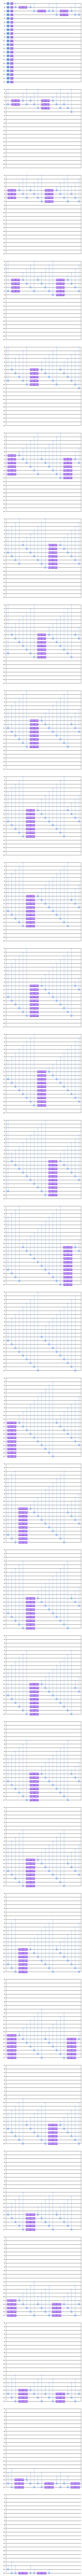

In [12]:
from qiskit.circuit.library import ZZFeatureMap

num_features = X.shape[1]

fmap = ZZFeatureMap(feature_dimension=num_features, reps=1)
fmap.decompose().draw(output = 'mpl', fold=20)

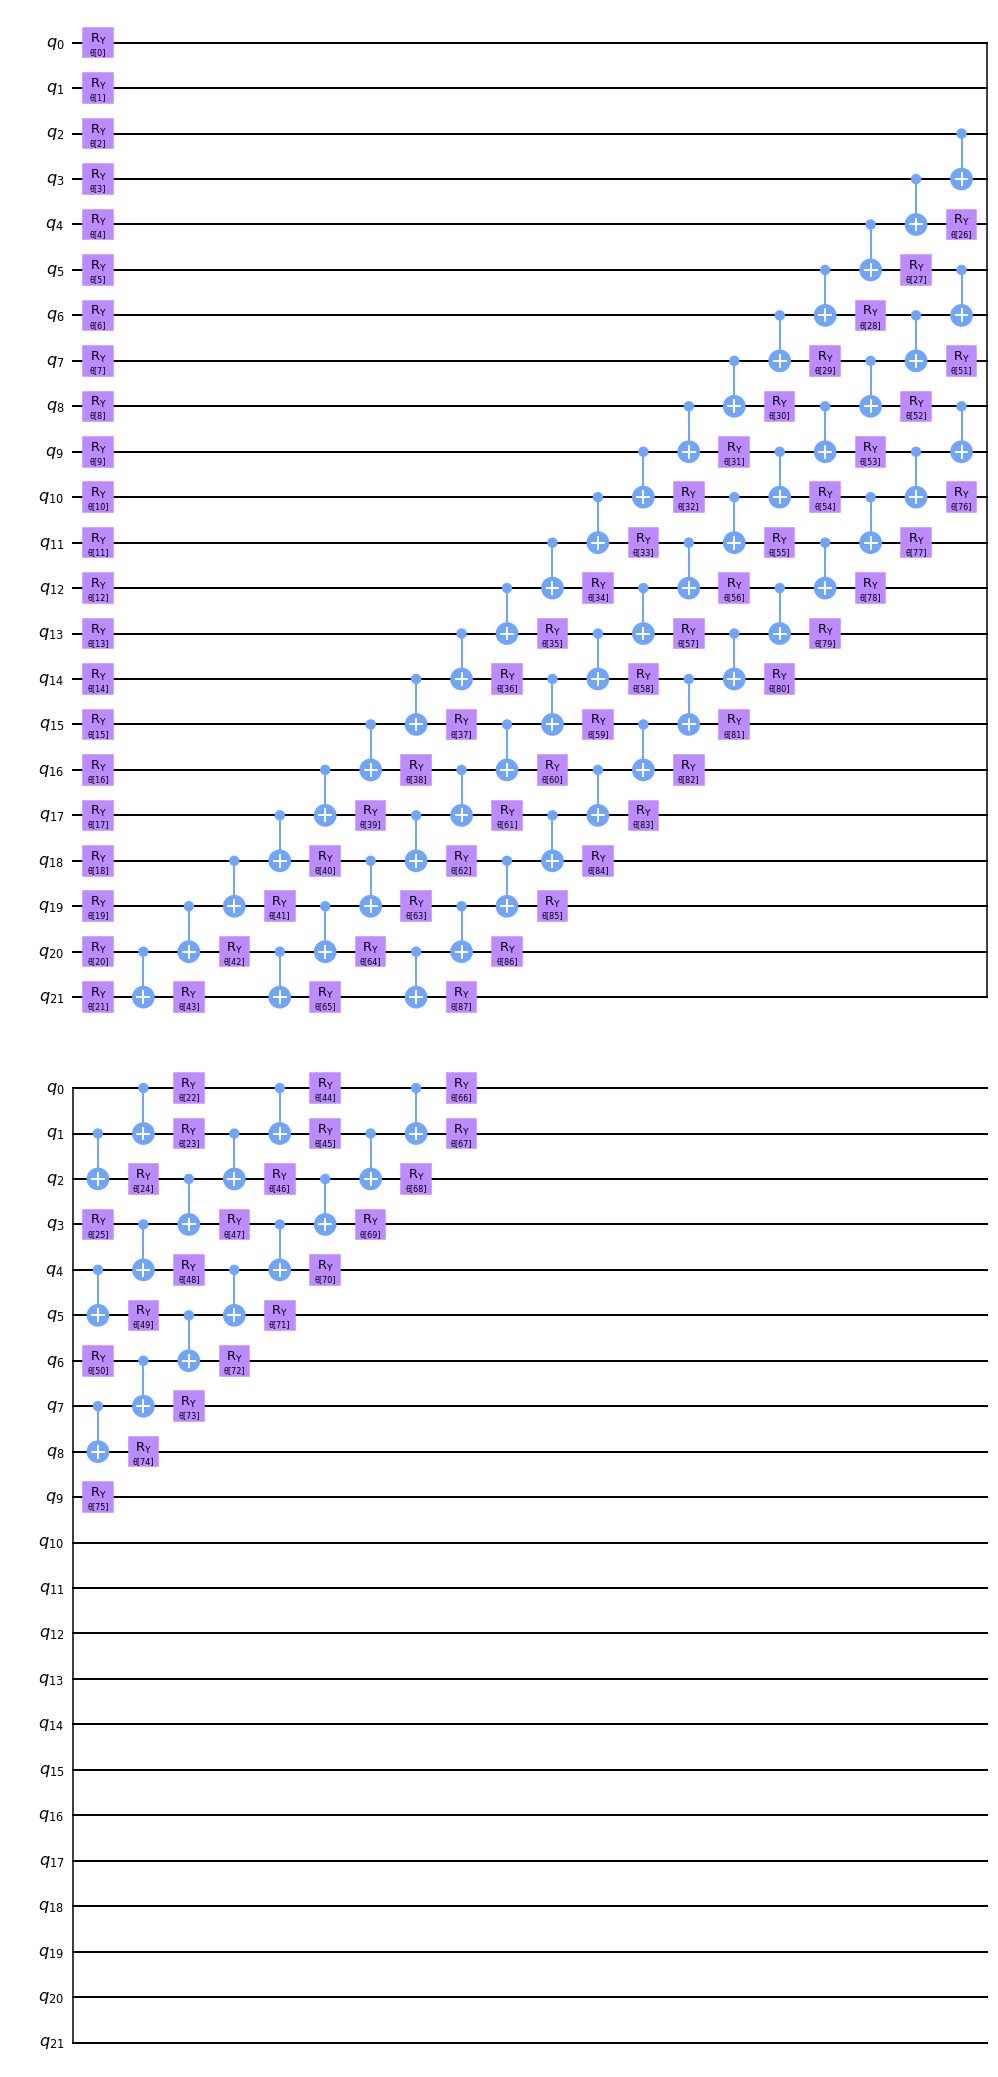

In [13]:
from qiskit.circuit.library import RealAmplitudes

ans = RealAmplitudes(num_qubits=num_features, reps=3)
ans.decompose().draw(output = 'mpl', fold = 20)

In [14]:
from qiskit.algorithms.optimizers import COBYLA

opt = COBYLA(maxiter=100)

In [15]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [16]:
from qiskit.primitives import Sampler

s = Sampler()

In [17]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(sampler = s, feature_map=fmap, ansatz=ans, optimizer=opt, callback=callback_graph)



# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

TypeError: __init__() got an unexpected keyword argument 'sampler'

In [ ]:
train_score = vqc.score(train_features, train_labels)
test_score = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score:.2f}")

In [ ]:
#We can consider the same algorithm but with a different ansatz

from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=num_features, reps=3)
optimizer = COBYLA(maxiter=40)

vqc = VQC(
    sampler = s,
    feature_map=fmap,
    ansatz=ans,
    optimizer=opt,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [ ]:
train_score_q2_eff = vqc.score(train_features, train_labels)
test_score_q2_eff = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q2_eff:.2f}")